This is a simple starter notebook to help you get started with the hackathon



In [1]:
!pip install catboost
!pip install optuna
!pip install scikit-learn xgboost

In [3]:
# import libraries
import os
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import xgboost as xgb

from xgboost import XGBRFRegressor


pd.options.display.float_format = '{:.5f}'.format

pd.options.display.max_rows = None

pd.options.display.max_columns = None

pd.options.display.max_colwidth = None



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Set seed for reproducability
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)


## Loading and previewing data

In [4]:
DATA_PATH = '/kaggle/input/yango-2025'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'Accra_weather.csv'), index_col=0)
variable_def = pd.read_csv(os.path.join(DATA_PATH, 'VariableDefinitions.csv'))

In [6]:
variable_def

,Attribute,Description
0,trip_id,Unique identifier for the trip
1,lcl_start_transporting_dt,Local date when the trip started
2,lcl_start_transporting_dttm,Local date and time when the trip started
3,lcl_order_finished_dttm,Local date and time when the trip ended
4,transporting_time_fact_mnt,Actual travel time in minutes
5,transporting_distance_fact_km,Actual travel distance in kilometers
6,str_distance_km,Straight-line distance in kilometers
7,origin_lat,Latitude of the starting point
8,origin_lon,Longitude of the starting point
9,destination_lat,Latitude of the destination point


In [4]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23


In [5]:
test.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km
0,ID_PV4QVE2H2X,5.659192,-0.128552,2024-05-28,2024-05-28 12:05:02,5.656207,-0.134396,0.673,1.241
1,ID_SUOBMO2E7V,5.664648,-0.143562,2024-05-07,2024-05-07 14:49:53,5.652780,-0.153714,1.802,2.650
2,ID_Q5KSL38U9B,5.642269,-0.152571,2024-05-18,2024-05-18 22:04:02,5.665573,-0.126283,3.833,6.015
3,ID_1G08NWYA35,5.695806,-0.118942,2024-05-25,2024-05-25 05:18:49,5.678735,-0.172577,6.219,7.987
4,ID_H7IZ8JL8YT,5.561824,-0.199377,2024-05-29,2024-05-29 16:55:24,5.551920,-0.196771,1.138,2.078


In [6]:
samplesubmission.head()

,trip_id,Target
0,ID_AH24RTKUMM,0
1,ID_1UH56FLC88,0
2,ID_014VH4SGZI,0
3,ID_J8HIZ307LQ,0
4,ID_ER6CPWJQ17,0


In [7]:
weather_df.head()

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C
lcl_date,,,,
2024-05-01,2024-05-01 00:00:00,Rain,0.001907,28.54
2024-05-01,2024-05-01 01:00:00,Rain,0.002861,28.51
2024-05-01,2024-05-01 02:00:00,Rain,0.002861,28.51
2024-05-01,2024-05-01 03:00:00,Rain,0.000954,28.53
2024-05-01,2024-05-01 04:00:00,Rain,0.001907,28.60


In [5]:
def extract_datetime_features(data, cols: list):
    df = data.copy()
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_month'] = df[col].dt.month

    return df

In [6]:
# extract datetime features
train = extract_datetime_features(train, ['lcl_start_transporting_dttm'])
test = extract_datetime_features(test, ['lcl_start_transporting_dttm'])
weather_df = extract_datetime_features(weather_df, ['lcl_datetime'])

# Preview train dataset
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_S3BD1V9G53,5.63093,-0.16921,2024-05-05,2024-05-05 09:56:32,5.63098,-0.16476,0.52900,0.85000,2.18000,9,5,5
1,ID_ZJM7LMN65Q,5.64504,-0.15648,2024-05-21,2024-05-21 10:53:32,5.68689,-0.11893,6.23000,8.72000,20.93000,10,21,5
2,ID_SZ3BP6V01V,5.71116,-0.14106,2024-05-05,2024-05-05 21:21:21,5.70601,-0.16500,2.70500,3.23900,13.02000,21,5,5
3,ID_5IPHXDCMKF,5.67750,-0.18335,2024-05-26,2024-05-26 21:23:33,5.66594,-0.18260,1.23600,1.41000,3.80000,21,26,5
4,ID_BYZEJ0B5RA,5.60170,-0.17359,2024-05-30,2024-05-30 14:02:13,5.56540,-0.16092,4.31200,6.55300,17.23000,14,30,5


In [10]:
# Preview test dataset
graph_df.isnull().sum()

NameError: name 'graph_df' is not defined

In [11]:
# Preview sample submission file
samplesubmission.head()

,trip_id,Target
0,ID_AH24RTKUMM,0
1,ID_1UH56FLC88,0
2,ID_014VH4SGZI,0
3,ID_J8HIZ307LQ,0
4,ID_ER6CPWJQ17,0


In [12]:
# Preview graph data
weather_df.head()

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
lcl_date,,,,,,,
2024-05-01,2024-05-01 00:00:00,Rain,0.001907,28.54,0,1,5
2024-05-01,2024-05-01 01:00:00,Rain,0.002861,28.51,1,1,5
2024-05-01,2024-05-01 02:00:00,Rain,0.002861,28.51,2,1,5
2024-05-01,2024-05-01 03:00:00,Rain,0.000954,28.53,3,1,5
2024-05-01,2024-05-01 04:00:00,Rain,0.001907,28.60,4,1,5


In [13]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape, weather_df.shape

((57596, 13), (24684, 12), (24684, 2), (744, 7))

In [14]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.3


## Statistical summaries

In [15]:
# Train statistical summary
train.describe(include = 'number')  # could also do include = 'all' or 'object'

,destination_lat,destination_lon,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
count,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000
mean,5.644267,-0.169131,5.644717,-0.169566,1.856562,3.170373,10.084202,13.591465,16.342645,5.000122
std,0.044116,0.041993,0.043378,0.041983,1.564909,2.855521,8.902421,5.493301,8.883002,0.011024
min,5.526851,-0.354872,5.527981,-0.349419,0.000000,0.501000,1.020000,0.000000,1.000000,5.000000
25%,5.622134,-0.187408,5.622675,-0.186448,0.934000,1.599000,5.270000,10.000000,9.000000,5.000000
50%,5.656059,-0.167765,5.657558,-0.167834,1.447000,2.379000,7.710000,14.000000,16.000000,5.000000
75%,5.675784,-0.149920,5.675472,-0.150483,2.245000,3.742000,12.030000,18.000000,24.000000,5.000000
max,5.754841,-0.047629,5.752558,-0.048585,18.120000,90.428000,585.930000,23.000000,31.000000,6.000000


Some insights from the above summary:
 - The train data provided has 57 596 data points
 - The average trip time is 10.08 mins
 - The shortest trip took a 1.02 minute while the longest took 585.93 mins (possible outliers)

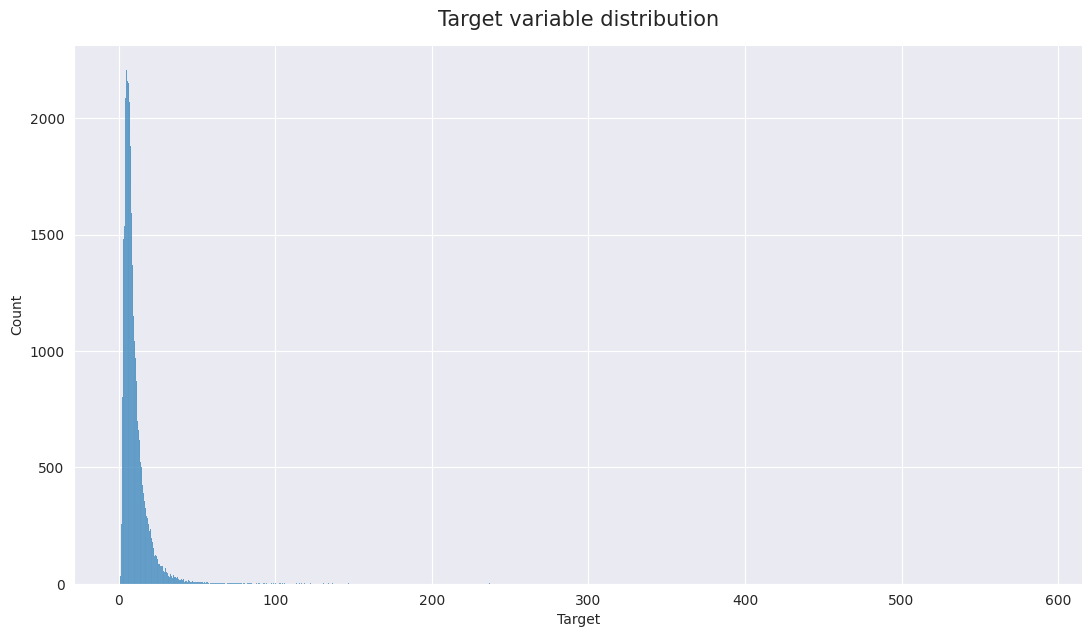

None

10.33424381562612

In [9]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.Target)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.Target.skew())

The target variable appears to be right skewed




## Outliers


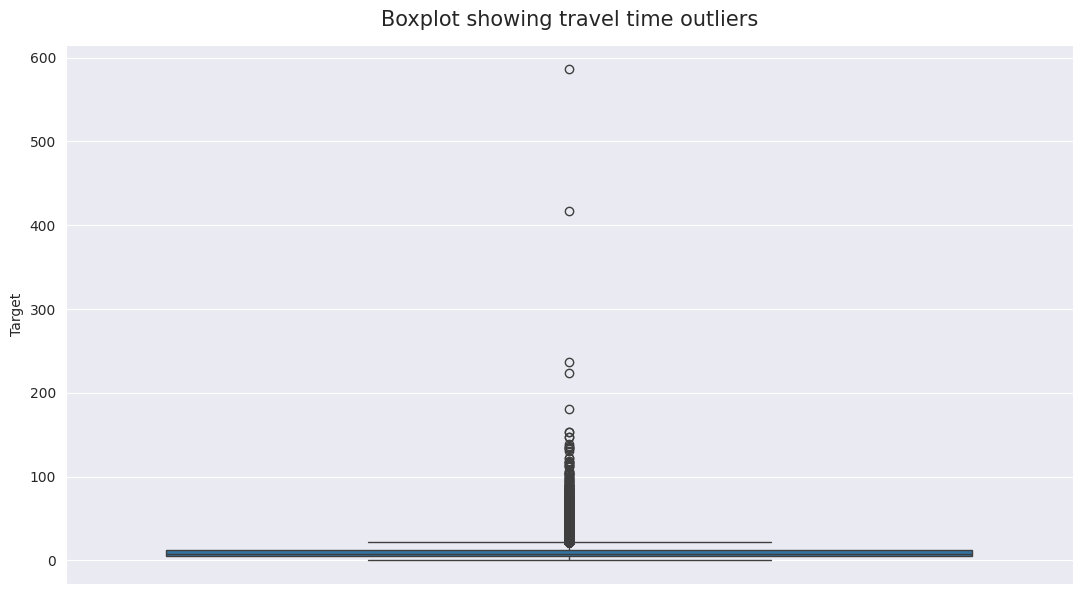

In [18]:
# Plotting boxplot for travel time
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.Target)
plt.title('Boxplot showing travel time outliers', y = 1.02, fontsize = 15)
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...



## Weather data

In [8]:
weather_df.lcl_datetime.min(), weather_df.lcl_datetime.max()

(Timestamp('2024-05-01 00:00:00'), Timestamp('2024-05-31 23:00:00'))

In [9]:
weather_df.describe(include='all')

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
count,744,744,744.000000,744.000000,744.000000,744.000000,744.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,Rain,NaN,NaN,NaN,NaN,NaN
freq,NaN,682,NaN,NaN,NaN,NaN,NaN
mean,2024-05-16 11:29:59.999999744,NaN,0.151697,28.299825,11.500000,16.000000,5.0
min,2024-05-01 00:00:00,NaN,0.000000,25.920000,0.000000,1.000000,5.0
25%,2024-05-08 17:45:00,NaN,0.000954,27.650000,5.750000,8.000000,5.0
50%,2024-05-16 11:30:00,NaN,0.012398,28.400000,11.500000,16.000000,5.0
75%,2024-05-24 05:15:00,NaN,0.076294,29.010000,17.250000,24.000000,5.0
max,2024-05-31 23:00:00,NaN,4.338264,30.490000,23.000000,31.000000,5.0


Some insights from the above summary:

 - An average of 0.151mm of precipitation was recorded in May 2024
 - Highest precipitation was 4.34mm
 - Average temp in May was 28.30 deg Celcius with a range between 25.92 and 30.49 degrees Celcius


In [16]:
weather_df["precipitation_type"].unique()

array(['Rain', 'No precipitation'], dtype=object)

Let's merge the weather and trips data

In [17]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,14,30,5


In [7]:
# For train
train['day'] = train['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0].astype(int)
train['hour'] = train['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0].astype(int)

# For test
test['day'] = test['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0].astype(int)
test['hour'] = test['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0].astype(int)

# For weather_df
weather_df['day'] = weather_df['lcl_datetime_day'].astype(str).str.split('.').str[0].astype(int)
weather_df['hour'] = weather_df['lcl_datetime_hour'].astype(str).str.split('.').str[0].astype(int)


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24684 entries, 0 to 24683
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   trip_id                            24684 non-null  object        
 1   destination_lat                    24684 non-null  float64       
 2   destination_lon                    24684 non-null  float64       
 3   lcl_start_transporting_dt          24684 non-null  object        
 4   lcl_start_transporting_dttm        24684 non-null  datetime64[ns]
 5   origin_lat                         24684 non-null  float64       
 6   origin_lon                         24684 non-null  float64       
 7   str_distance_km                    24684 non-null  float64       
 8   transporting_distance_fact_km      24684 non-null  float64       
 9   lcl_start_transporting_dttm_hour   24684 non-null  int32         
 10  lcl_start_transporting_dttm_day   

In [8]:
train = train.merge(weather_df, on=['day', 'hour'], how='left')
test = test.merge(weather_df, on=['day', 'hour'], how='left')

In [14]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,...,lcl_start_transporting_dttm_month,day,hour,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,...,5,5,9,2024-05-05 09:00:00,Rain,0.012875,28.74,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,...,5,21,10,2024-05-21 10:00:00,Rain,0.001907,29.32,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,...,5,5,21,2024-05-05 21:00:00,Rain,0.001907,29.54,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,...,5,26,21,2024-05-26 21:00:00,No precipitation,0.000000,28.49,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,...,5,30,14,2024-05-30 14:00:00,No precipitation,0.019073,29.38,14,30,5


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57596 entries, 0 to 57595
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   trip_id                            57596 non-null  object        
 1   destination_lat                    57596 non-null  float64       
 2   destination_lon                    57596 non-null  float64       
 3   lcl_start_transporting_dt          57596 non-null  object        
 4   lcl_start_transporting_dttm        57596 non-null  datetime64[ns]
 5   origin_lat                         57596 non-null  float64       
 6   origin_lon                         57596 non-null  float64       
 7   str_distance_km                    57596 non-null  float64       
 8   transporting_distance_fact_km      57596 non-null  float64       
 9   Target                             57596 non-null  float64       
 10  lcl_start_transporting_dttm_hour  


## Missing values and duplicates

In [15]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [65]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

## Encode Precipitation col

In [9]:
from sklearn.preprocessing import LabelEncoder

def encode_precipitation_type(train_df, test_df, col='precipitation_type'):
    le = LabelEncoder()
    # Fit on both train and test to handle all possible categories
    all_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(all_values)
    train_df[f'{col}_encoded'] = le.transform(train_df[col].astype(str))
    test_df[f'{col}_encoded'] = le.transform(test_df[col].astype(str))
    return train_df, test_df

train, test = encode_precipitation_type(train, test, col='precipitation_type')


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57596 entries, 0 to 57595
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   trip_id                            57596 non-null  object        
 1   destination_lat                    57596 non-null  float64       
 2   destination_lon                    57596 non-null  float64       
 3   lcl_start_transporting_dt          57596 non-null  object        
 4   lcl_start_transporting_dttm        57596 non-null  datetime64[ns]
 5   origin_lat                         57596 non-null  float64       
 6   origin_lon                         57596 non-null  float64       
 7   str_distance_km                    57596 non-null  float64       
 8   transporting_distance_fact_km      57596 non-null  float64       
 9   Target                             57596 non-null  float64       
 10  lcl_start_transporting_dttm_hour  

In [10]:
train.drop(columns=['precipitation_type'], inplace=True)
test.drop(columns=['precipitation_type'], inplace=True)
weather_df.drop(columns=['precipitation_type'], inplace=True)


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24684 entries, 0 to 24683
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   trip_id                            24684 non-null  object        
 1   destination_lat                    24684 non-null  float64       
 2   destination_lon                    24684 non-null  float64       
 3   lcl_start_transporting_dt          24684 non-null  object        
 4   lcl_start_transporting_dttm        24684 non-null  datetime64[ns]
 5   origin_lat                         24684 non-null  float64       
 6   origin_lon                         24684 non-null  float64       
 7   str_distance_km                    24684 non-null  float64       
 8   transporting_distance_fact_km      24684 non-null  float64       
 9   lcl_start_transporting_dttm_hour   24684 non-null  int32         
 10  lcl_start_transporting_dttm_day   


## Correlations

In [22]:
# Top 20 correlated features to the target
top20_corrs = abs(train.select_dtypes(include='number').corr()['Target']).sort_values(ascending = False).head(20)
top20_corrs

Target                               1.000000
transporting_distance_fact_km        0.831081
str_distance_km                      0.455688
origin_lon                           0.037094
destination_lon                      0.026450
lcl_datetime_hour_y                  0.024966
lcl_start_transporting_dttm_hour     0.024966
lcl_datetime_hour_x                  0.024966
origin_lat                           0.017035
precipitation_type_y_encoded         0.013073
lcl_datetime_day_y                   0.011372
lcl_datetime_day_x                   0.011372
lcl_start_transporting_dttm_day      0.011372
temperature_C_x                      0.004476
temperature_C_y                      0.004476
prev_hour_precipitation_mm_x         0.003572
prev_hour_precipitation_mm_y         0.003572
destination_lat                      0.003378
lcl_start_transporting_dttm_month    0.002502
lcl_datetime_month_x                      NaN
Name: Target, dtype: float64

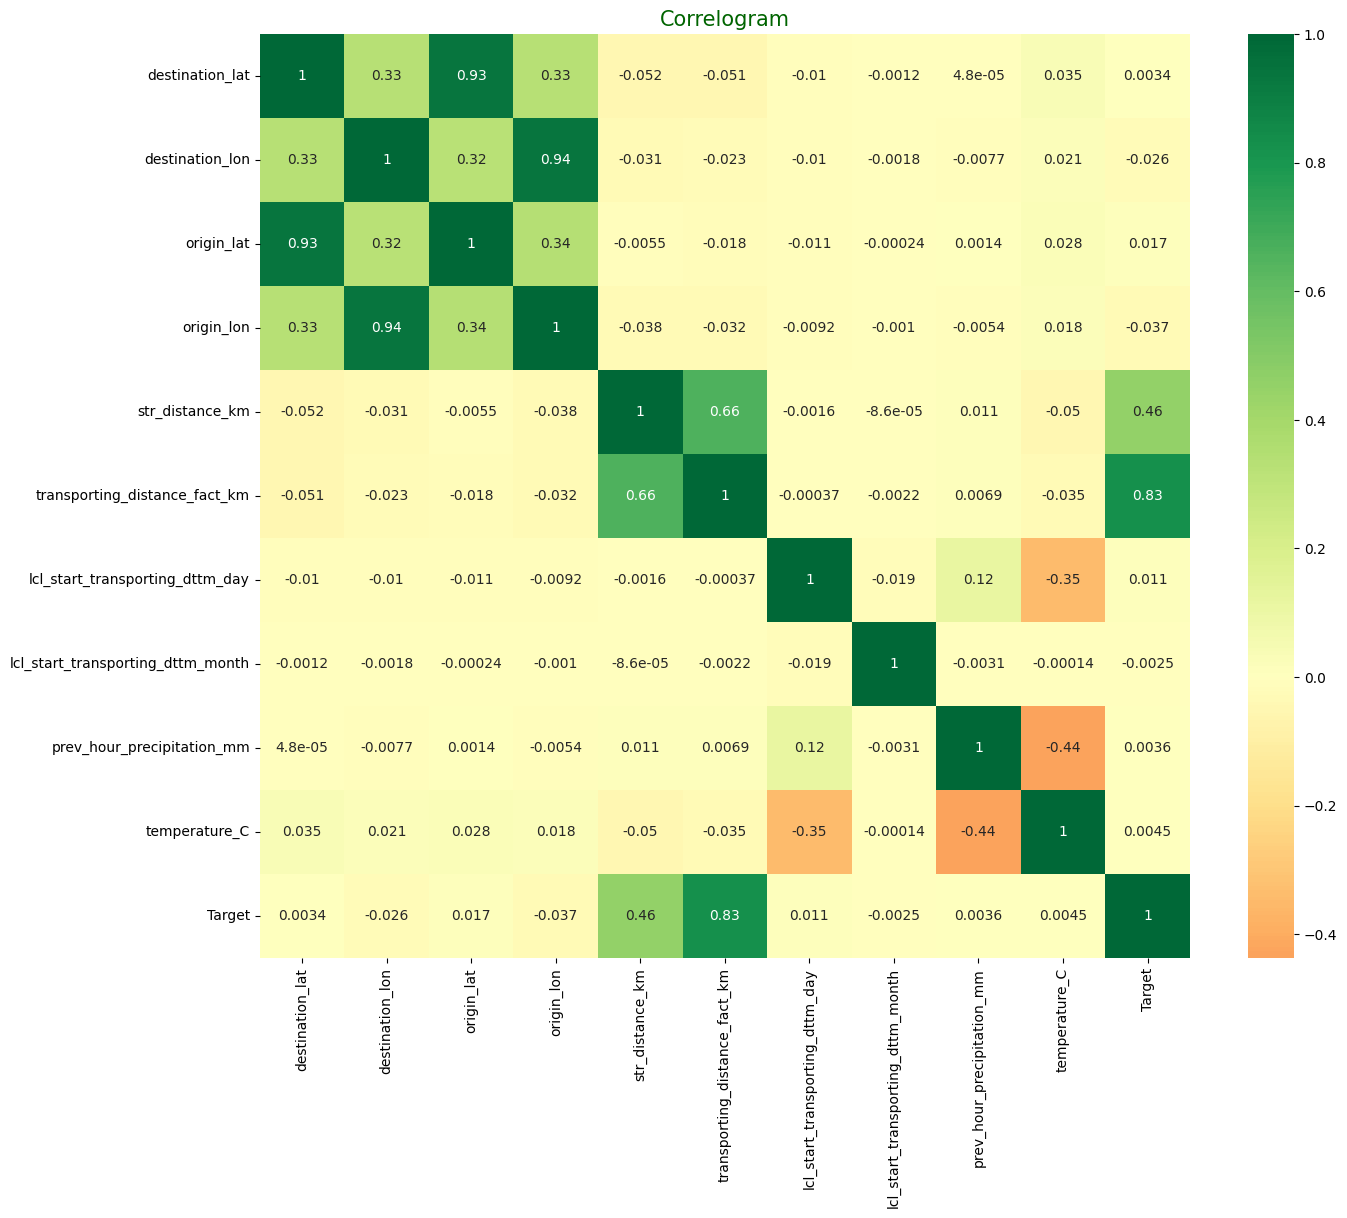

In [67]:
cols = ['destination_lat','destination_lon','origin_lat','origin_lon',
        'str_distance_km','transporting_distance_fact_km', 'lcl_start_transporting_dttm_day',
        'lcl_start_transporting_dttm_month', 'prev_hour_precipitation_mm', 'temperature_C', 'Target']

# Plotting a heatmap to show correlations between variables
corr = train[cols].corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

## Add Lag Features

In [11]:
# Columns we never want as features:
exclude_cols = [
    'trip_id',
    'Target',  # drop the real target too
    'lcl_datetime',
    'lcl_start_transporting_dttm',
    'lcl_start_transporting_dt',
    'lcl_datetime_y',
    'lcl_datetime_x'
]

# Start from all train columns, remove excludes + anything containing “target”
feat_cols = [
    c for c in train.columns
    if c not in exclude_cols
       and 'target' not in c.lower()
]

# Finally, intersect with test.columns so we don’t pick up stray names
safe_features = [c for c in feat_cols if c in test.columns]

# print("Final feature list:", safe_features)


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24684 entries, 0 to 24683
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   trip_id                            24684 non-null  object        
 1   destination_lat                    24684 non-null  float64       
 2   destination_lon                    24684 non-null  float64       
 3   lcl_start_transporting_dt          24684 non-null  object        
 4   lcl_start_transporting_dttm        24684 non-null  datetime64[ns]
 5   origin_lat                         24684 non-null  float64       
 6   origin_lon                         24684 non-null  float64       
 7   str_distance_km                    24684 non-null  float64       
 8   transporting_distance_fact_km      24684 non-null  float64       
 9   lcl_start_transporting_dttm_hour   24684 non-null  int32         
 10  lcl_start_transporting_dttm_day   

In [14]:
# Lag Features for train
train_num_agg = train.groupby("trip_id")[safe_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]

train_num_agg.reset_index(inplace = True)



for col in train_num_agg:

  if 'last' in col and col.replace('last', 'first') in train_num_agg:

    train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]

    train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]



#

In [15]:
# Lag Featuresfor test
test_num_agg = test.groupby("trip_id")[safe_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])

test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

test_num_agg.reset_index(inplace = True)



for col in test_num_agg:

  if 'last' in col and col.replace('last', 'first') in test_num_agg:

    test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]

    test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

In [16]:
train = train.merge(train_num_agg, how = 'inner', on = 'trip_id')
test = test.merge(test_num_agg, how='left', on='trip_id')
test.fillna(-1, inplace=True)


In [17]:
leaks = [c for c in train.columns if 'target' in c.lower() and c!='target']
print("Leaky columns:", leaks)


Leaky columns: ['Target']


In [75]:
print(train.filter(like='Target').columns)
# Index(['Target'], dtype='object')


Index(['Target'], dtype='object')


In [60]:
# 1a. Drop all columns that have “target” in their name except the true one
leak_cols = [c for c in train.columns 
             if 'target' in c.lower() and c.lower() != 'target']
train.drop(columns=leak_cols, inplace=True)

# 1b. Now safely drop the true 'Target' from your features list
feature_cols = [c for c in train.columns 
                if c.lower() not in ['target'] and c not in exclude_cols]


In [61]:
print("Any target in features? ", any('target' in c.lower() for c in feature_cols))
# Should print False


Any target in features?  False


In [39]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,...,temperature_C_last_lag_sub,temperature_C_last_lag_div,lcl_datetime_hour_last_lag_sub,lcl_datetime_hour_last_lag_div,lcl_datetime_day_last_lag_sub,lcl_datetime_day_last_lag_div,lcl_datetime_month_last_lag_sub,lcl_datetime_month_last_lag_div,precipitation_type_encoded_last_lag_sub,precipitation_type_encoded_last_lag_div
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,...,0.0,1.0,0,1.0,0,1.0,0,1.0,0,1.0
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,...,0.0,1.0,0,1.0,0,1.0,0,1.0,0,1.0
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,...,0.0,1.0,0,1.0,0,1.0,0,1.0,0,1.0
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,...,0.0,1.0,0,1.0,0,1.0,0,1.0,0,NaN
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,...,0.0,1.0,0,1.0,0,1.0,0,1.0,0,NaN


In [27]:
train[safe_features]

,destination_lat,destination_lon,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month,day,hour,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month,precipitation_type_encoded
0,5.630927,-0.169211,5.630979,-0.164760,0.529,0.850,9,5,5,5,9,0.012875,28.74,9,5,5,1
1,5.645044,-0.156482,5.686892,-0.118931,6.230,8.720,10,21,5,21,10,0.001907,29.32,10,21,5,1
2,5.711156,-0.141063,5.706008,-0.164999,2.705,3.239,21,5,5,5,21,0.001907,29.54,21,5,5,1
3,5.677497,-0.183350,5.665943,-0.182602,1.236,1.410,21,26,5,26,21,0.000000,28.49,21,26,5,0
4,5.601700,-0.173589,5.565401,-0.160919,4.312,6.553,14,30,5,30,14,0.019073,29.38,14,30,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57591,5.651375,-0.205847,5.667825,-0.187878,2.645,3.178,22,19,5,19,22,0.000000,28.72,22,19,5,1
57592,5.678648,-0.189866,5.672013,-0.176552,1.579,2.697,21,8,5,8,21,0.000954,29.12,21,8,5,1
57593,5.642874,-0.095244,5.644604,-0.081823,1.541,3.285,20,18,5,18,20,0.000000,28.50,20,18,5,0
57594,5.571064,-0.230571,5.564688,-0.231522,0.776,1.182,13,9,5,9,13,0.000477,29.52,13,9,5,1



## Modelling

### RandomForestRegressor

In [20]:
# Selecting the independent variables and the target variable
# feature_cols = ['str_distance_km', 'temperature_C','transporting_distance_fact_km',
#            'lcl_start_transporting_dttm_day', 'prev_hour_precipitation_mm','origin_lon', 'destination_lon', 'origin_lat', 'destination_lat']

X = train[safe_features].fillna(-1)
y = train.Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Score: 4.134211143463359


In [24]:
train.columns

Index(['trip_id', 'destination_lat', 'destination_lon',
       'lcl_start_transporting_dt', 'lcl_start_transporting_dttm',
       'origin_lat', 'origin_lon', 'str_distance_km',
       'transporting_distance_fact_km', 'Target',
       ...
       'temperature_C_last_lag_sub', 'temperature_C_last_lag_div',
       'lcl_datetime_hour_last_lag_sub', 'lcl_datetime_hour_last_lag_div',
       'lcl_datetime_day_last_lag_sub', 'lcl_datetime_day_last_lag_div',
       'lcl_datetime_month_last_lag_sub', 'lcl_datetime_month_last_lag_div',
       'precipitation_type_encoded_last_lag_sub',
       'precipitation_type_encoded_last_lag_div'],
      dtype='object', length=158)

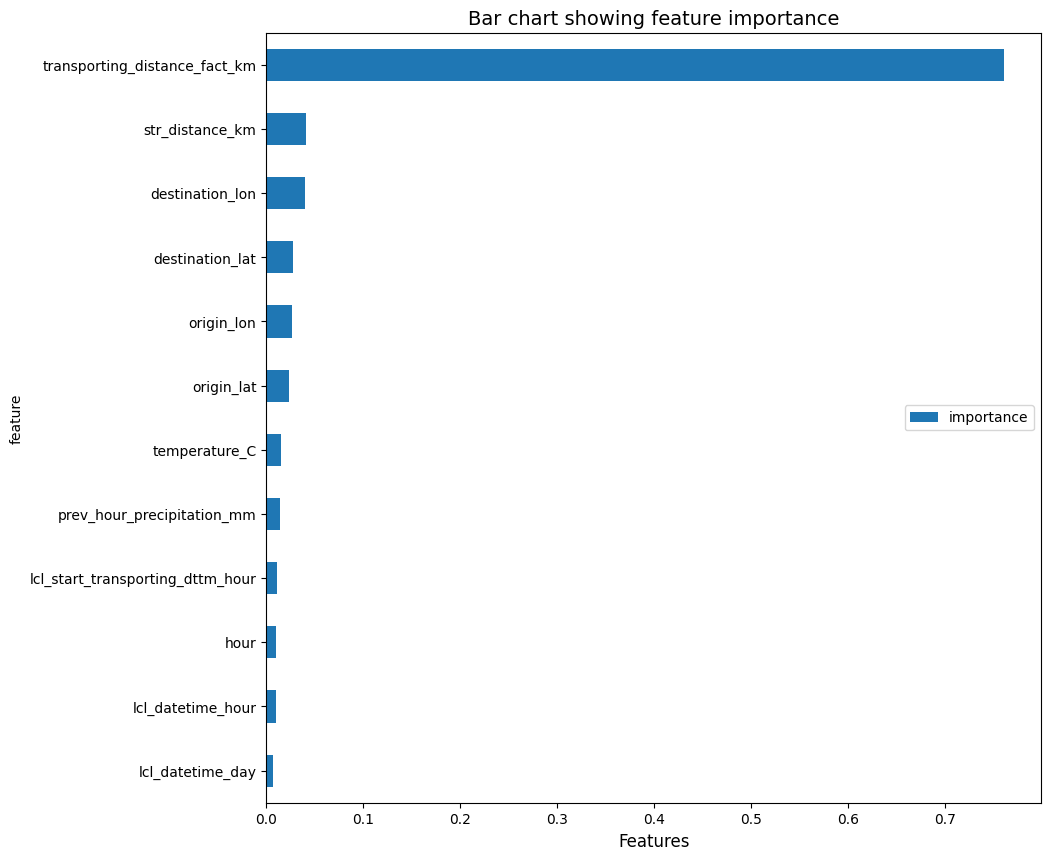

In [22]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [25]:
df_train = train.copy()
df_test = test.copy()

<Axes: xlabel='fold'>

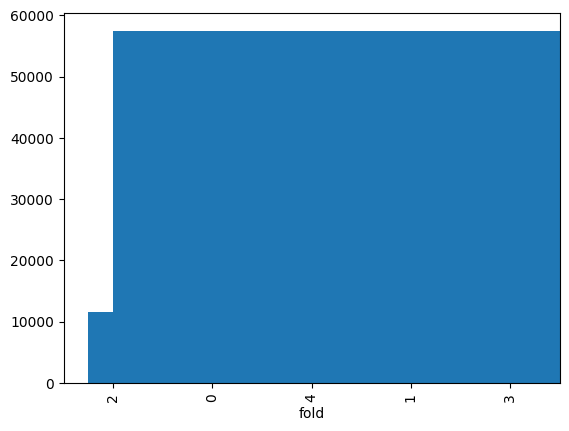

In [26]:
from sklearn.model_selection import StratifiedGroupKFold


# Sturge's rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df_train)))))



df_train['bins'] = pd.cut(df_train['Target'], bins=num_bins, labels=False)

df_train['bins'].hist()

df_train['fold'] = -1



groups = np.array(df_train['trip_id'].values)



N_FOLDS = 5

strat_kfold = StratifiedGroupKFold(n_splits=N_FOLDS, random_state=42, shuffle=True)

for i, (_, train_index) in enumerate(strat_kfold.split(df_train.index, df_train['bins'], groups=groups)):

    df_train.iloc[train_index, -1] = i



df_train['fold'] = df_train['fold'].astype('int')



df_train.fold.value_counts().plot.bar()

## XGB 

In [28]:
preds =[]



for fold in range(N_FOLDS):



  print(f'Training on fold {fold}')



  train_data = df_train[df_train.fold != fold].reset_index(drop=True)

  valid_data = df_train[df_train.fold == fold].reset_index(drop=True)



  xtrain, ytrain = train_data[safe_features].fillna(-1), train_data.Target

  xvalid, yvalid = valid_data[safe_features].fillna(-1), valid_data.Target




  dtrain = xgb.DMatrix(xtrain, ytrain)



  xgb_params = {

      'eta': 0.11487104976141894,

      'max_depth': 7,

      'objective': 'reg:squarederror',

      'eval_metric': 'rmse',

      'lambda': 0.025821457658986833,

      'alpha': 0.03060308988047964,

      'base_score': np.mean(ytrain),

      'gpu_id': 0,

      'tree_method': 'gpu_hist',

      'num_parallel_tree': 3

  }



  num_boost_rounds = 1843

  model = xgb.train(

      dict(xgb_params, silent=False),

      dtrain,

      num_boost_round=num_boost_rounds

  )




  dval = xgb.DMatrix(xvalid, yvalid)



  # vl_mse = root_mean_squared_error(yvalid, model.predict(dval))
  vl_mse = mean_squared_error(yvalid, model.predict(dval), squared=False)

  print(f"fold {fold} rmse: ", vl_mse)



  dtest = xgb.DMatrix(df_test[safe_features].fillna(-1))

  pred = model.predict(dtest)



  preds.append(pred)


Training on fold 0
fold 0 rmse:  4.013747617811068
Training on fold 1
fold 1 rmse:  4.347455666015098
Training on fold 2
fold 2 rmse:  4.530226346772136
Training on fold 3
fold 3 rmse:  3.807954282269283
Training on fold 4
fold 4 rmse:  6.745295479388298


In [29]:
predictions = np.mean(preds, 0)

In [32]:

sub_file = pd.DataFrame({'trip_id': df_test.trip_id, 'Target': predictions})

sub_file.head()

,trip_id,Target
0,ID_PV4QVE2H2X,4.92489
1,ID_SUOBMO2E7V,6.50097
2,ID_Q5KSL38U9B,13.11913
3,ID_1G08NWYA35,20.73831
4,ID_H7IZ8JL8YT,7.68198


## Neural


## Making predictions of the test set and creating a submission file

In [33]:
# Create file for xgb

sub_file.to_csv('yango_2025_xgb.csv', index = False) # Download subfile and submit to zindi for scoring

In [34]:
# Make prediction on the test set for regression
test_df = test[safe_features].fillna(-1)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'trip_id': test.trip_id, 'Target': predictions})
sub_file.head()

,trip_id,Target
0,ID_PV4QVE2H2X,5.06560
1,ID_SUOBMO2E7V,8.07890
2,ID_Q5KSL38U9B,14.98550
3,ID_1G08NWYA35,22.98190
4,ID_H7IZ8JL8YT,8.02310


In [35]:
# Create file
sub_file.to_csv('RFRegressor.csv', index = False) # Download subfile and submit to zindi for scoring

## Blend

In [45]:
sub1 = pd.read_csv('/kaggle/working/yango_2025_xgb.csv')
sub2 = pd.read_csv('/kaggle/working/RFRegressor.csv')

sub2['Target']= 0.4*sub1['Target'] + 0.6*sub2['Target']

In [47]:
sub2.to_csv('yango_blend-4-6.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;